<a href="https://colab.research.google.com/github/MahdiNouraie/RNN-and-Transformers/blob/main/Simple_RNN_MSFT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [ ]:
! pip install yfinance

In [3]:
import yfinance as yf

In [4]:
ms = yf.download('MSFT' ,
                            start = '2012-01-01',
                            end = '2021-12-31',
                            progress = False )
df = ms[['Adj Close' , 'Open' , 'Close' , 'High' , 'Low' ]].round(3)
df

,Adj Close,Open,Close,High,Low
Date,,,,,
2012-01-03,21.573,26.55,26.77,26.96,26.39
2012-01-04,22.081,26.82,27.40,27.47,26.78
2012-01-05,22.306,27.38,27.68,27.73,27.29
2012-01-06,22.653,27.53,28.11,28.19,27.53
2012-01-09,22.355,28.05,27.74,28.10,27.72
...,...,...,...,...,...
2021-12-23,333.223,332.75,334.69,336.39,332.73
2021-12-27,340.949,335.46,342.45,342.48,335.43
2021-12-28,339.755,343.15,341.25,343.81,340.32


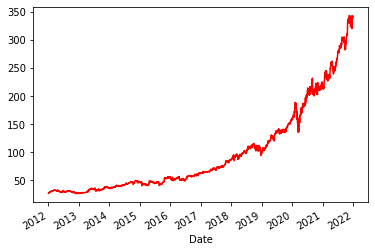

In [5]:
df.Close.plot(color = 'red')

In [6]:
def ts_data(df , X_steps , y_steps):
  train_df = df[:'2020'].Close.values.reshape(-1,1)
  test_df = df['2021':].Close.values.reshape(-1,1)

  sc = MinMaxScaler(feature_range = (0,1))
  train_df_scaled = sc.fit_transform(train_df)

  X_train = []
  y_train = []
  for i in range(X_steps , len(train_df_scaled) - (y_steps -1)):
    X_train.append(train_df_scaled[i - X_steps : i , 0])
    y_train.append(train_df_scaled[i : i + y_steps , 0])
  X_train = np.array(X_train)
  y_train = np.array(y_train)

  X_train = X_train.reshape(X_train.shape[0] , X_train.shape[1] , 1)

  X = df.Close.values
  X = X[len(X) - len(test_df) - X_steps : ]
  X = X.reshape(-1,1)
  X = sc.fit_transform(X)

  X_test = []
  y_test = []
  for i in range(X_steps , len(test_df) + X_steps - y_steps):
    X_test.append(X[i - X_steps : i , 0])
    y_test.append(X[i : i + y_steps , 0])

  X_test = np.array(X_test)
  X_test = X_test.reshape(X_test.shape[0] , X_test.shape[1] , 1)
  y_test = np.array(y_test)

  return X_train , y_train , X_test , y_test, sc


In [7]:
X_train , y_train , X_test , y_test , sc = ts_data(df , 6 , 2)

In [8]:
X_train[0:3]

array([[[0.00194856],
        [0.00501754],
        [0.00638153],
        [0.00847623],
        [0.00667381],
        [0.00716095]],

       [[0.00501754],
        [0.00638153],
        [0.00847623],
        [0.00667381],
        [0.00716095],
        [0.00657638]],

       [[0.00638153],
        [0.00847623],
        [0.00667381],
        [0.00716095],
        [0.00657638],
        [0.00794037]]])

In [9]:
y_train[0:3]

array([[0.00657638, 0.00794037],
       [0.00794037, 0.00915822],
       [0.00915822, 0.00920694]])

# Simple RNN


In [10]:
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN

In [11]:
simple_rnn_model = Sequential([
                               SimpleRNN(50 , return_sequences = True),
                               SimpleRNN(50),
                               Dense(2)
                                                ])

In [12]:
simple_rnn_model.compile(optimizer = 'Adam' , loss = 'mean_squared_error')

In [13]:
simple_rnn_model.fit(X_train , y_train , epochs = 100 , validation_split = 0.15)

Epoch 1/100
60/60 [==============================] - 5s 17ms/step - loss: 0.0014 - val_loss: 0.0193
Epoch 2/100
60/60 [==============================] - 1s 12ms/step - loss: 1.2653e-04 - val_loss: 0.0096
Epoch 3/100
60/60 [==============================] - 1s 13ms/step - loss: 1.2630e-04 - val_loss: 0.0063
Epoch 4/100
60/60 [==============================] - 1s 12ms/step - loss: 1.0263e-04 - val_loss: 0.0042
Epoch 5/100
60/60 [==============================] - 1s 12ms/step - loss: 9.8675e-05 - val_loss: 0.0027
Epoch 6/100
60/60 [==============================] - 1s 13ms/step - loss: 1.5408e-04 - val_loss: 0.0038
Epoch 7/100
60/60 [==============================] - 1s 13ms/step - loss: 1.0394e-04 - val_loss: 0.0031
Epoch 8/100
60/60 [==============================] - 1s 12ms/step - loss: 7.3472e-05 - val_loss: 0.0030
Epoch 9/100
60/60 [==============================] - 1s 12ms/step - loss: 1.2760e-04 - val_loss: 0.0031
Epoch 10/100
60/60 [==============================] - 1s 13ms/step -

In [14]:
simple_rnn_pred = simple_rnn_model.predict(X_test)

In [15]:
def prediction_plot(predictions):
  fig , ax = plt.subplots()
  ax.plot(df['2021': ].index[: len(y_test)] , sc.inverse_transform(y_test[: , 0].reshape(-1,1)) , label = 'real')
  ax.plot(df['2021': ].index[: len(y_test)] , sc.inverse_transform(predictions[: , 0].reshape(-1,1)) , label = 'prediction')

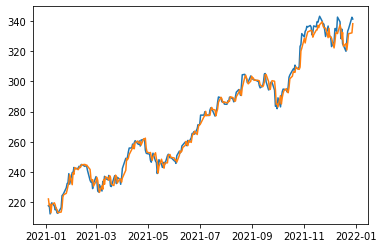

In [16]:
prediction_plot(simple_rnn_pred)